In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor, StackingRegressor)
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from sklearn.multioutput import MultiOutputRegressor
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
try:
    df = pd.read_csv('BPDB_Data1.csv')
    print("Dataset loaded successfully.")
    print("Shape of the raw data:", df.shape)
except FileNotFoundError:
    print("Error: 'BPDB_Data1.csv' not found. Please make sure the file is in the correct directory.")

Dataset loaded successfully.
Shape of the raw data: (1701, 43)


In [4]:
print("--- Starting Advanced Feature Engineering ---")

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
invalid_dates_count = df['Date'].isnull().sum()
if invalid_dates_count > 0:
    print(f"Found and removed {invalid_dates_count} row(s) with invalid dates.")
    df.dropna(subset=['Date'], inplace=True)

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Outcome/Target Columns (Zone-wise demand)
target_columns = [
    'Dhaka_Dem_Eve', 'Chattogram_Dem_Eve', 'Khulna_Dem_Eve', 'Rajshahi_Dem_Eve',
    'Cumilla_Dem_Eve', 'Mymensingh_Dem_Eve', 'Sylhet_Dem_Eve',
    'Barishal_Dem_Eve', 'Rangpur_Dem_Eve'
]

# Time-based features
df['day'] = df.index.day
df['month'] = df.index.month
df['weekday'] = df.index.weekday # Monday=0, Sunday=6
df['is_weekend'] = df['weekday'].isin([4, 5]).astype(int)  # Friday & Saturday in Bangladesh

# Rolling and lag features for each target zone
for col in target_columns:
    df[f'{col}_rolling3'] = df[col].rolling(window=3).mean()
    df[f'{col}_rolling7'] = df[col].rolling(window=7).mean()
    df[f'{col}_lag1'] = df[col].shift(1)

# Drop rows with NaNs created by rolling/lag features
df.dropna(inplace=True)

# Define final feature and target sets
y = df[target_columns]
feature_columns = [col for col in df.columns if col not in target_columns]
X = df[feature_columns]

print("Feature engineering complete.")
print(f"Final feature shape after engineering: {X.shape}")
print(f"Final target shape after engineering: {y.shape}")

--- Starting Advanced Feature Engineering ---
Found and removed 3 row(s) with invalid dates.
Feature engineering complete.
Final feature shape after engineering: (1593, 64)
Final target shape after engineering: (1593, 9)


In [5]:
# Import the new scaler
from sklearn.preprocessing import MinMaxScaler

# Split the data. For time series, it's best not to shuffle.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data splitting and scaling complete using MinMaxScaler.")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

Data splitting and scaling complete using MinMaxScaler.
Training data shape: (1274, 64)
Testing data shape: (319, 64)


In [6]:
from sklearn.model_selection import GridSearchCV

print("--- Starting GridSearchCV for MLP ---")
print("This will take a few minutes...")

# Define the model
mlp = MLPRegressor(max_iter=1000, random_state=42)

# Define the grid of parameters to test
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30)],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['relu', 'tanh']
}

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# Run the search on your training data
grid_search.fit(X_train_scaled, y_train)

# Print the best combination of settings found
print("\n--- Best MLP Parameters Found ---")
print(grid_search.best_params_)


--- Starting GridSearchCV for MLP ---
This will take a few minutes...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

--- Best MLP Parameters Found ---
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}


In [7]:
print("\n--- Training and Evaluating Base Models ---")

results = {}
regressors = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR": SVR(C=10, gamma='auto'),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=100, random_state=42, verbose=0, loss_function='MultiRMSE'),
    "Bagging": BaggingRegressor(n_estimators=100, random_state=42),
    "MLP": MLPRegressor(
        hidden_layer_sizes=(100,),
        activation='relu',
        alpha=0.0001,
        max_iter=1000,
        random_state=42
    )
}

for name, model in regressors.items():
    print(f"\nTraining {name}...")
    # List of models that need the MultiOutputRegressor wrapper
    if name in ["SVR", "AdaBoost", "Gradient Boosting", "LightGBM"]:
        wrapped_model = MultiOutputRegressor(model)
        wrapped_model.fit(X_train_scaled, y_train)
        y_pred = wrapped_model.predict(X_test_scaled)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    # Calculate and store metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": mse, "R2 Score": r2}
    print(f"{name} -> MAE: {mae:.4f}, MSE: {mse:.4f}, R2 Score: {r2:.4f}")


--- Training and Evaluating Base Models ---

Training Linear Regression...
Linear Regression -> MAE: 2.3259, MSE: 212.9135, R2 Score: 0.9918

Training Decision Tree...
Decision Tree -> MAE: 69.8652, MSE: 9848.2644, R2 Score: 0.7404

Training SVR...
SVR -> MAE: 111.0719, MSE: 42805.8567, R2 Score: 0.6722

Training KNN...
KNN -> MAE: 81.6222, MSE: 16921.8266, R2 Score: 0.7836

Training Random Forest...
Random Forest -> MAE: 46.2800, MSE: 4272.7411, R2 Score: 0.8640

Training Gradient Boosting...
Gradient Boosting -> MAE: 11.4709, MSE: 506.0287, R2 Score: 0.9840

Training AdaBoost...
AdaBoost -> MAE: 35.7687, MSE: 2790.5116, R2 Score: 0.9486

Training XGBoost...
XGBoost -> MAE: 13.5416, MSE: 760.8336, R2 Score: 0.9794

Training LightGBM...
LightGBM -> MAE: 13.7837, MSE: 681.7877, R2 Score: 0.9833

Training CatBoost...
CatBoost -> MAE: 69.9156, MSE: 10606.7073, R2 Score: 0.7947

Training Bagging...
Bagging -> MAE: 46.9458, MSE: 4391.7537, R2 Score: 0.8601

Training MLP...
MLP -> MAE: 141.

In [8]:
print("\n--- Training and Evaluating Ensemble Models ---")

# Define the base estimators for ensembling
estimators = [
    ('Random Forest', regressors['Random Forest']),
    ('LightGBM', regressors['LightGBM']),
    ('XGBoost', regressors['XGBoost'])
]

# Voting Regressor
print("\nTraining Voting Regressor...")
# Create the base voting regressor
voting_regressor_base = VotingRegressor(estimators=estimators, n_jobs=-1)
# Wrap the VotingRegressor with MultiOutputRegressor
wrapped_voting_regressor = MultiOutputRegressor(estimator=voting_regressor_base)
wrapped_voting_regressor.fit(X_train_scaled, y_train)
y_pred_voting = wrapped_voting_regressor.predict(X_test_scaled)

results["Ensemble (Voting)"] = {
    "MAE": mean_absolute_error(y_test, y_pred_voting),
    "MSE": mean_squared_error(y_test, y_pred_voting),
    "R2 Score": r2_score(y_test, y_pred_voting)
}
print(f"Ensemble (Voting) -> R2 Score: {results['Ensemble (Voting)']['R2 Score']:.4f}")

# Stacking Regressor
print("\nTraining Stacking Regressor...")
# Create the base stacking regressor
stacking_regressor_base = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), n_jobs=-1)
# Wrap the StackingRegressor with MultiOutputRegressor
wrapped_stacking_regressor = MultiOutputRegressor(estimator=stacking_regressor_base)
wrapped_stacking_regressor.fit(X_train_scaled, y_train)
y_pred_stacking = wrapped_stacking_regressor.predict(X_test_scaled)

results["Ensemble (Stacking)"] = {
    "MAE": mean_absolute_error(y_test, y_pred_stacking),
    "MSE": mean_squared_error(y_test, y_pred_stacking),
    "R2 Score": r2_score(y_test, y_pred_stacking)
}
print(f"Ensemble (Stacking) -> R2 Score: {results['Ensemble (Stacking)']['R2 Score']:.4f}")


--- Training and Evaluating Ensemble Models ---

Training Voting Regressor...
Ensemble (Voting) -> R2 Score: 0.9836

Training Stacking Regressor...
Ensemble (Stacking) -> R2 Score: 0.9841


In [9]:
print("--- Preparing Sequential Data for LSTM ---")


# Use the time-based features and the demand (target) columns
features_for_lstm = ['day', 'month', 'weekday', 'is_weekend'] + target_columns
df_lstm = df[features_for_lstm].copy()

# Scale all features to the 0-1 range
scaler_lstm = MinMaxScaler()
df_lstm_scaled = scaler_lstm.fit_transform(df_lstm)

# --- Create the "windows" ---
X_sequences = []
y_sequences = []
n_steps = 7 # Use 7 days of history to predict the next day

# Loop through the data to create sequences
for i in range(n_steps, len(df_lstm_scaled)):
    # The input sequence (X) is the past 'n_steps' days
    X_sequences.append(df_lstm_scaled[i-n_steps:i, :])
    # The output (y) is the demand columns of the next day
    y_sequences.append(df_lstm_scaled[i, 4:]) # Target columns start at index 4

# Convert lists to numpy arrays
X_lstm_seq = np.array(X_sequences)
y_lstm_seq = np.array(y_sequences)

# Split the sequential data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm_seq, y_lstm_seq, test_size=0.2, random_state=42, shuffle=False
)

print(f"Shape of LSTM training input (X): {X_train_lstm.shape}")
print("Shape format is (samples, timesteps, features)")

--- Preparing Sequential Data for LSTM ---
Shape of LSTM training input (X): (1268, 7, 13)
Shape format is (samples, timesteps, features)


In [10]:
print("\n--- Training Improved LSTM Model on Sequential Data ---")

# A more robust, stacked LSTM architecture
lstm_model_new = Sequential([
    # Input shape is (timesteps, features)
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),

    # First LSTM layer
    LSTM(100, return_sequences=True),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(50),
    Dropout(0.2),

    # Output layer with a neuron for each of the 9 target columns
    Dense(y_train_lstm.shape[1])
])

lstm_model_new.compile(optimizer='adam', loss='mse')
lstm_model_new.summary()

print("\nTraining new LSTM model (this may take a few moments)...")
history = lstm_model_new.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

# Evaluate the new LSTM model
y_pred_lstm_new = lstm_model_new.predict(X_test_lstm)

# IMPORTANT: The predictions are scaled, so we need to inverse transform them
# to calculate the true metrics.
dummy_array = np.zeros((y_test_lstm.shape[0], len(features_for_lstm)))
dummy_array[:, 4:] = y_test_lstm
y_test_inversed = scaler_lstm.inverse_transform(dummy_array)[:, 4:]

dummy_array[:, 4:] = y_pred_lstm_new
y_pred_inversed = scaler_lstm.inverse_transform(dummy_array)[:, 4:]

# CORRECTED: Calculate all three metrics on the unscaled data
mae_lstm_new = mean_absolute_error(y_test_inversed, y_pred_inversed)
mse_lstm_new = mean_squared_error(y_test_inversed, y_pred_inversed)
r2_lstm_new = r2_score(y_test_inversed, y_pred_inversed)

# CORRECTED: Add all three metrics to the results dictionary
results["LSTM (Improved)"] = {
    "MAE": mae_lstm_new,
    "MSE": mse_lstm_new,
    "R2 Score": r2_lstm_new
}

print(f"\nImproved LSTM -> MAE: {mae_lstm_new:.4f}, MSE: {mse_lstm_new:.4f}, R2 Score: {r2_lstm_new:.4f}")


--- Training Improved LSTM Model on Sequential Data ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 100)         │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,259 (297.89 KB)

 Trainable params: 76,259 (297.89 KB)

 Non-trainable params: 0 (0.00 B)


Training new LSTM model (this may take a few moments)...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Improved LSTM -> MAE: 86.9625, MSE: 20854.2074, R2 Score: 0.7232


In [11]:
print("\n--- Final Results Summary ---")

results_df = pd.DataFrame(results).T
results_df_sorted = results_df.sort_values(by='R2 Score', ascending=False)


print(results_df_sorted)


--- Final Results Summary ---
                            MAE           MSE  R2 Score
Linear Regression      2.325932    212.913512  0.991754
Ensemble (Stacking)   13.410713    618.706778  0.984141
Gradient Boosting     11.470873    506.028692  0.983981
Ensemble (Voting)     11.608469    588.312632  0.983648
LightGBM              13.783660    681.787680  0.983279
XGBoost               13.541615    760.833618  0.979438
AdaBoost              35.768656   2790.511642  0.948596
Random Forest         46.280001   4272.741123  0.863961
Bagging               46.945762   4391.753678  0.860083
CatBoost              69.915640  10606.707263  0.794664
KNN                   81.622153  16921.826625  0.783639
Decision Tree         69.865204   9848.264368  0.740391
LSTM (Improved)       86.962502  20854.207398  0.723178
SVR                  111.071856  42805.856723  0.672230
MLP                  141.434031  66181.440337  0.109194


Bar chart has been created and saved as 'model_r2_comparison.png'


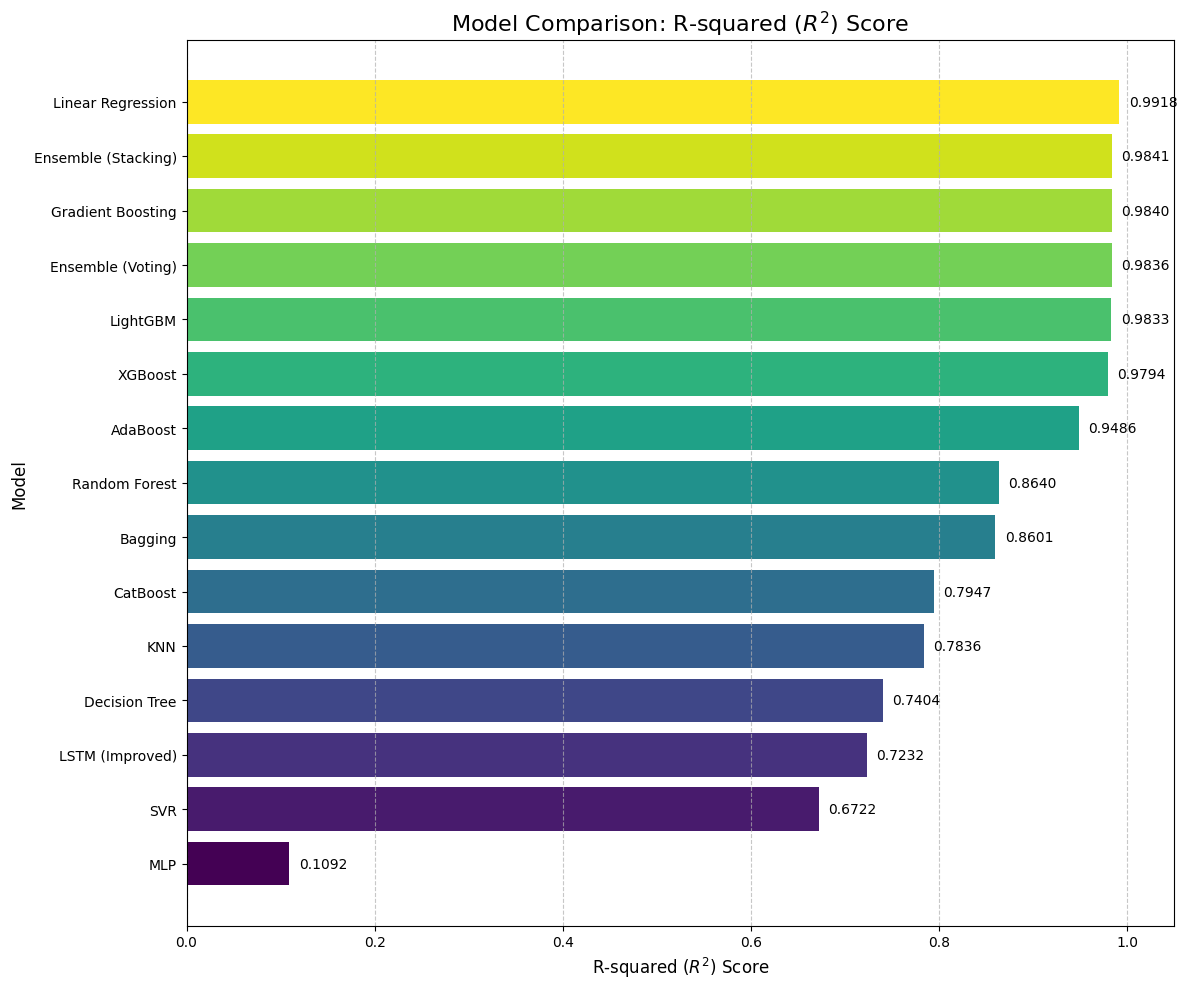

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results).T

# Sort the DataFrame by R2 Score for plotting
results_df_sorted = results_df.sort_values(by='R2 Score', ascending=False)

# --- Create the Bar Chart ---
# Reverse the order for a top-to-bottom display (highest score at the top)
plot_df = results_df_sorted.iloc[::-1]

# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(plot_df)))

plt.figure(figsize=(12, 10))
bars = plt.barh(plot_df.index, plot_df['R2 Score'], color=colors)

# Add the R2 score value label to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{width:.4f}',
        ha='left',
        va='center'
    )

# Set titles and labels for clarity
plt.title('Model Comparison: R-squared ($R^2$) Score', fontsize=16)
plt.xlabel('R-squared ($R^2$) Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.05)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
plt.savefig('model_r2_comparison.png')

print("Bar chart has been created and saved as 'model_r2_comparison.png'")

In [13]:
# --- Evaluation Metrics for the Stacking Model ---

stacking_results = results['Ensemble (Stacking)']
mae = stacking_results['MAE']
mse = stacking_results['MSE']
r2 = stacking_results['R2 Score']

print("--- Evaluation Metrics for Ensemble (Stacking) Model ---")
print(f"R-squared (R2 Score): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

--- Evaluation Metrics for Ensemble (Stacking) Model ---
R-squared (R2 Score): 0.9841
Mean Absolute Error (MAE): 13.41
Mean Squared Error (MSE): 618.71


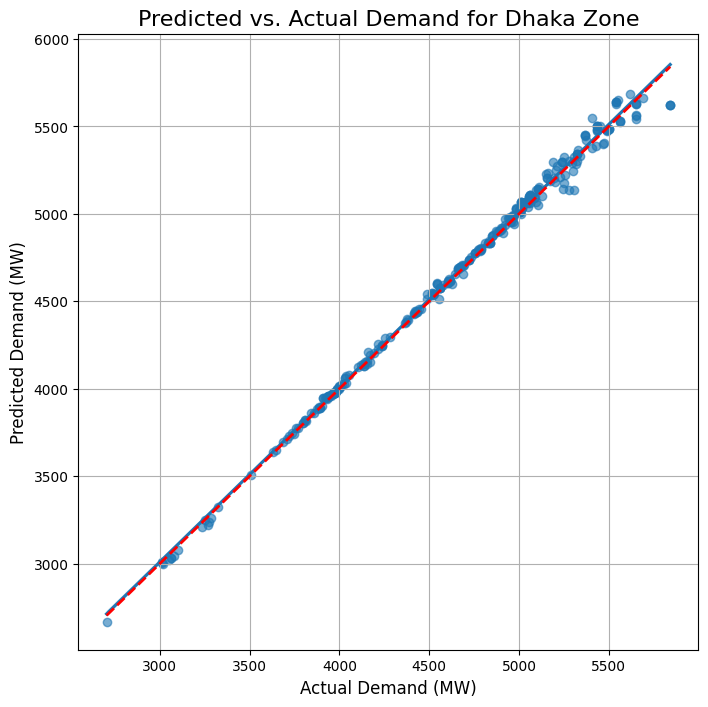

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Predicted vs. Actual Plot ---
dhaka_actual = y_test['Dhaka_Dem_Eve']
dhaka_pred = y_pred_stacking[:, 0] # Dhaka is the first column

plt.figure(figsize=(8, 8))
sns.regplot(x=dhaka_actual, y=dhaka_pred, scatter_kws={'alpha':0.6})

# Add a line for perfect predictions
plt.plot([min(dhaka_actual), max(dhaka_actual)], [min(dhaka_actual), max(dhaka_actual)], color='red', linestyle='--', lw=2)

plt.title('Predicted vs. Actual Demand for Dhaka Zone', fontsize=16)
plt.xlabel('Actual Demand (MW)', fontsize=12)
plt.ylabel('Predicted Demand (MW)', fontsize=12)
plt.grid(True)
plt.show()

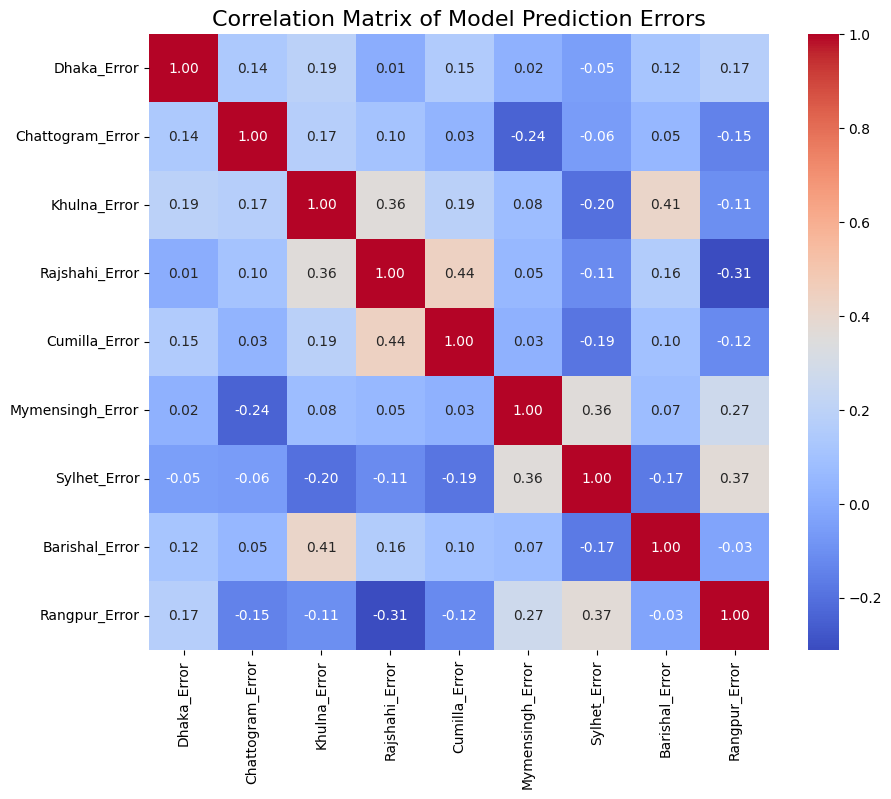

In [15]:
# --- Correlation Matrix of Prediction Errors ---

# Calculate the errors
errors = y_test - y_pred_stacking

# Rename the columns for clarity
errors.columns = [f"{col.split('_')[0]}_Error" for col in y_test.columns]

# Calculate the correlation matrix of these errors
error_corr = errors.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(error_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Model Prediction Errors', fontsize=16)
plt.show()

--- Generating Actual vs. Predicted Plots for 2022-2023 ---


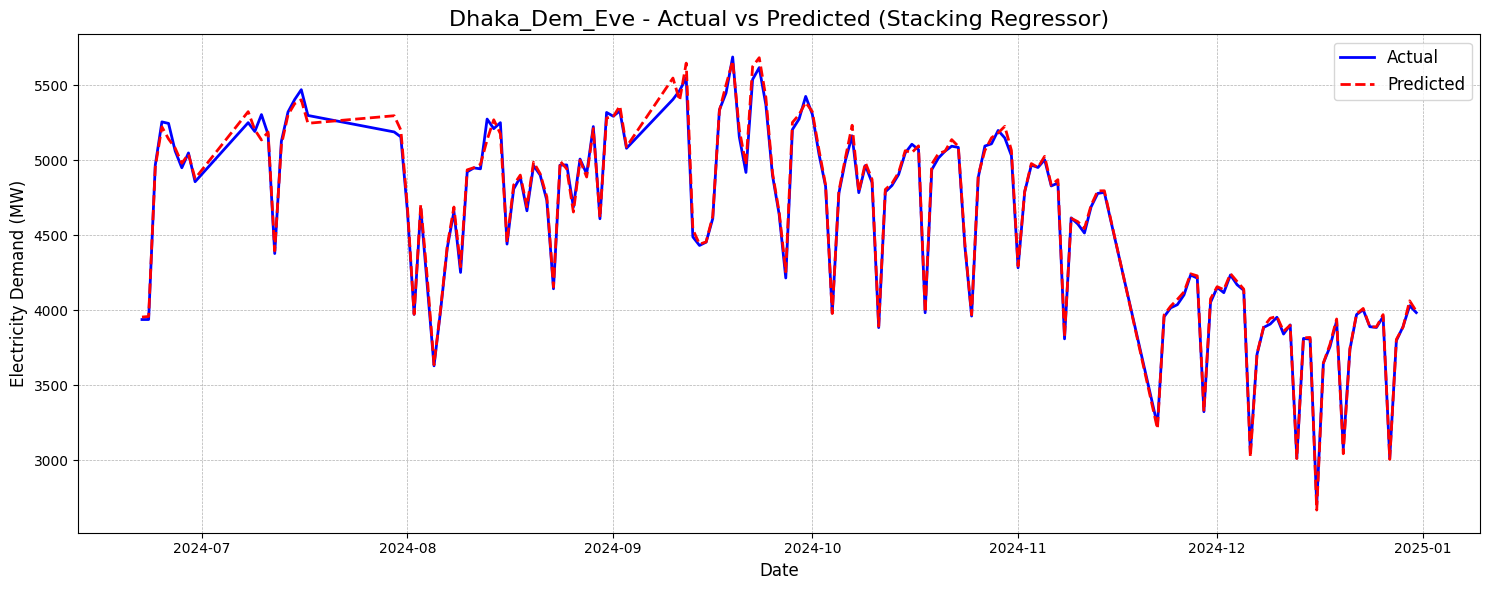

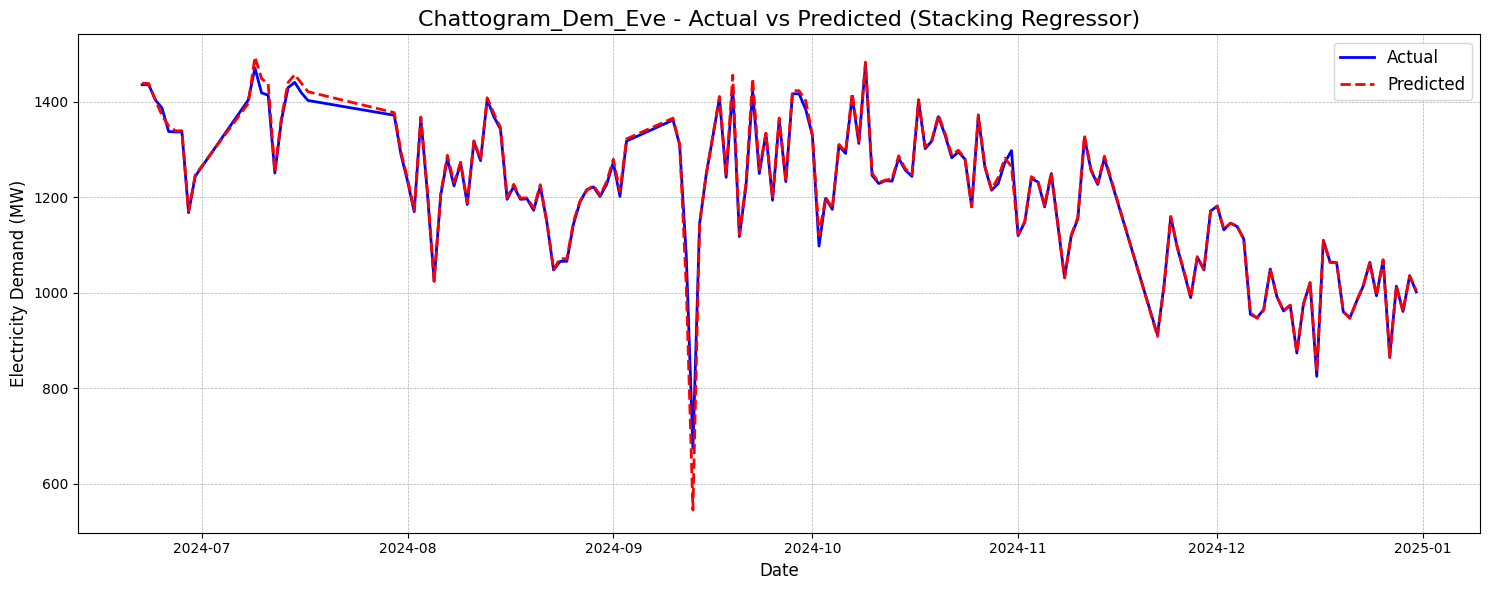

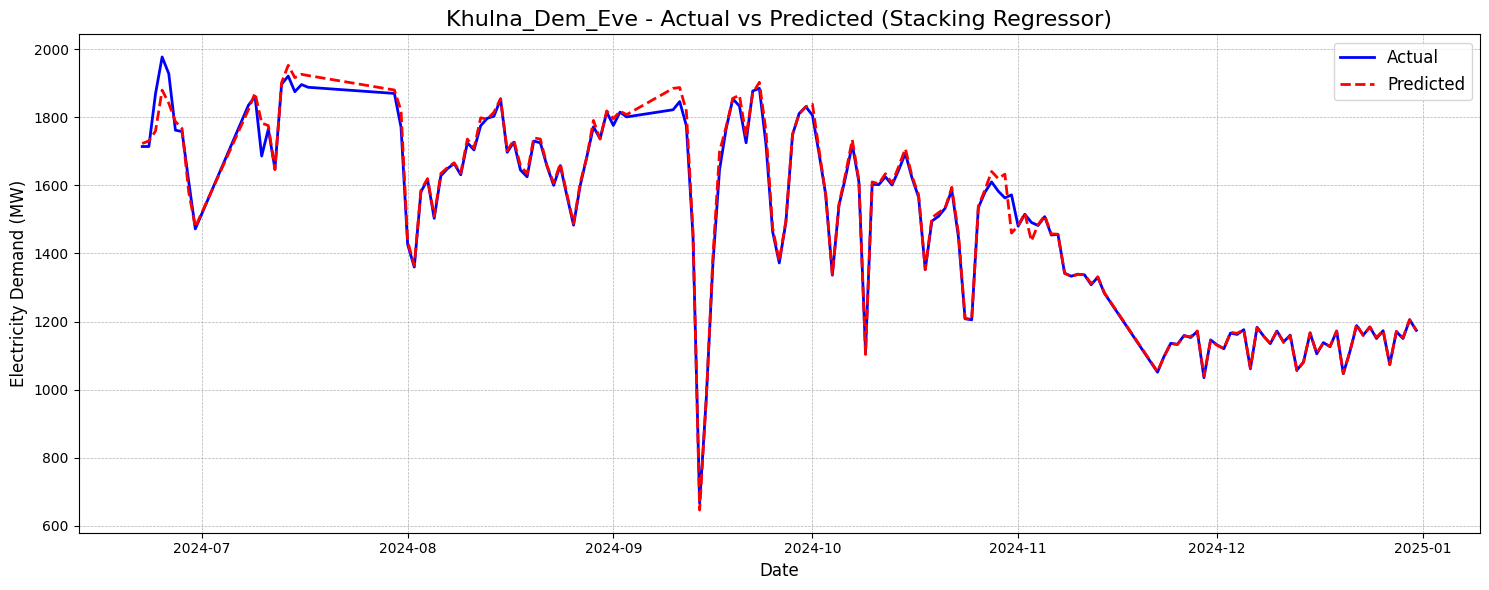

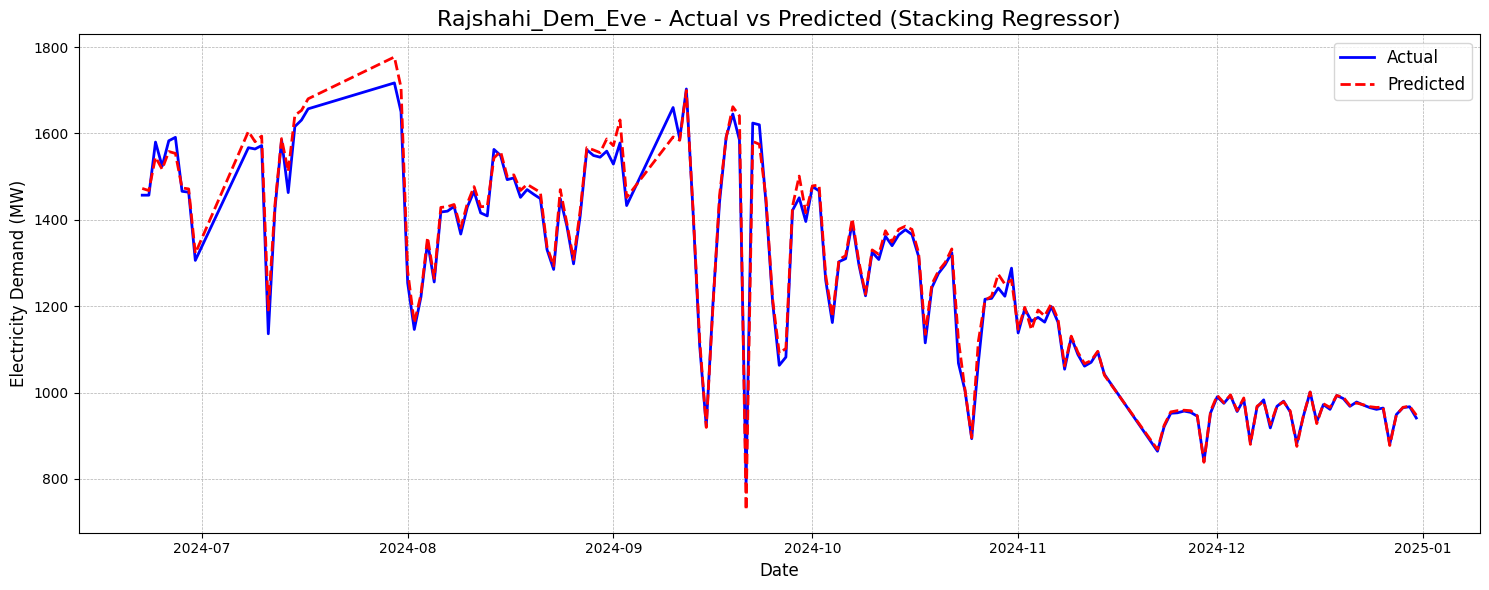

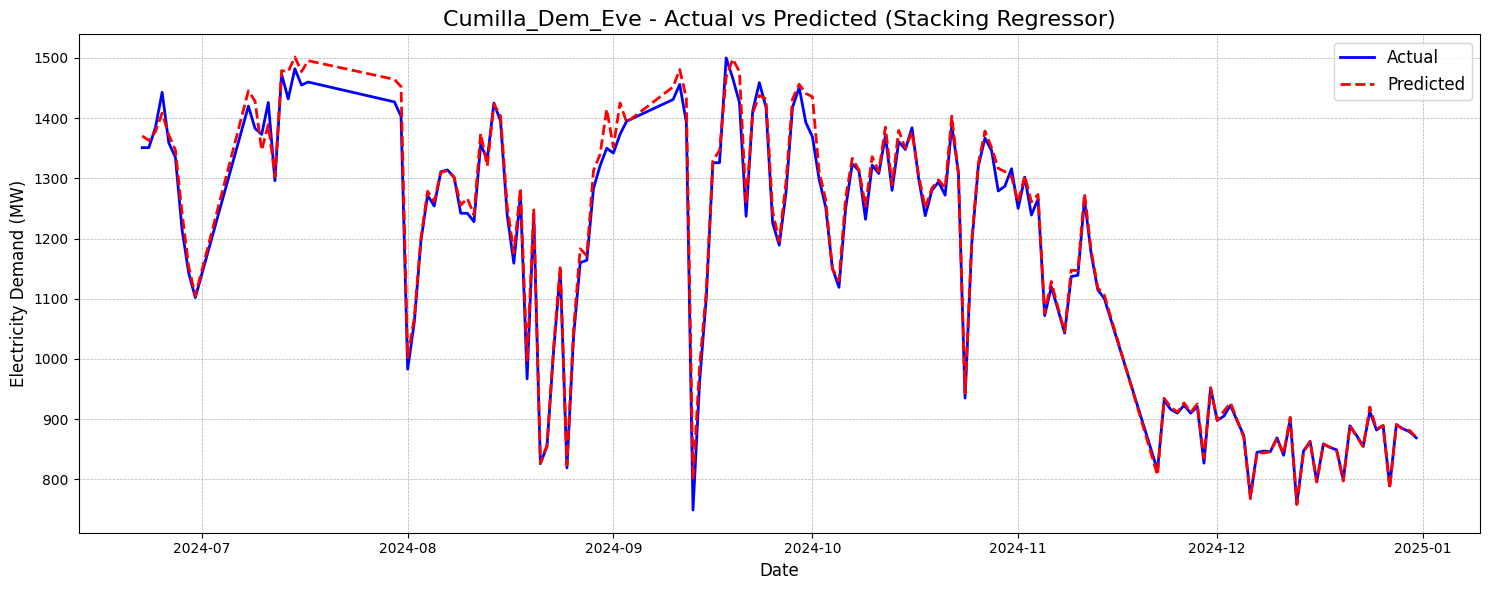

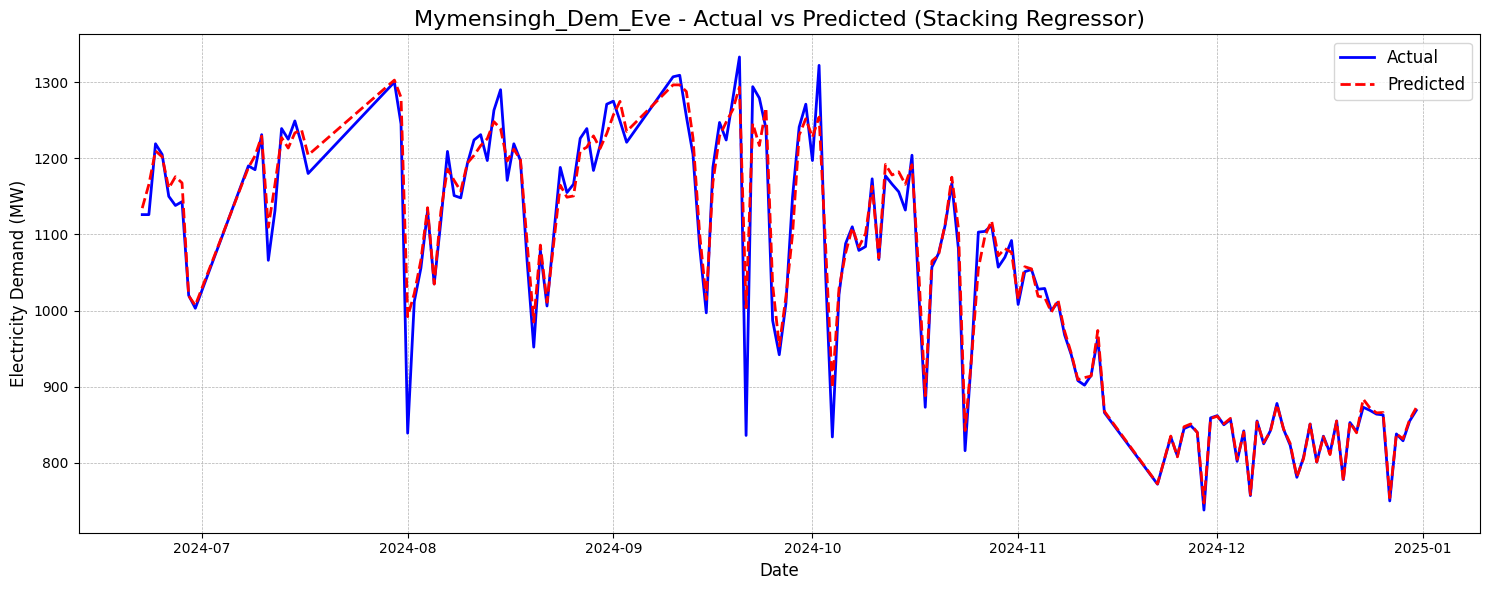

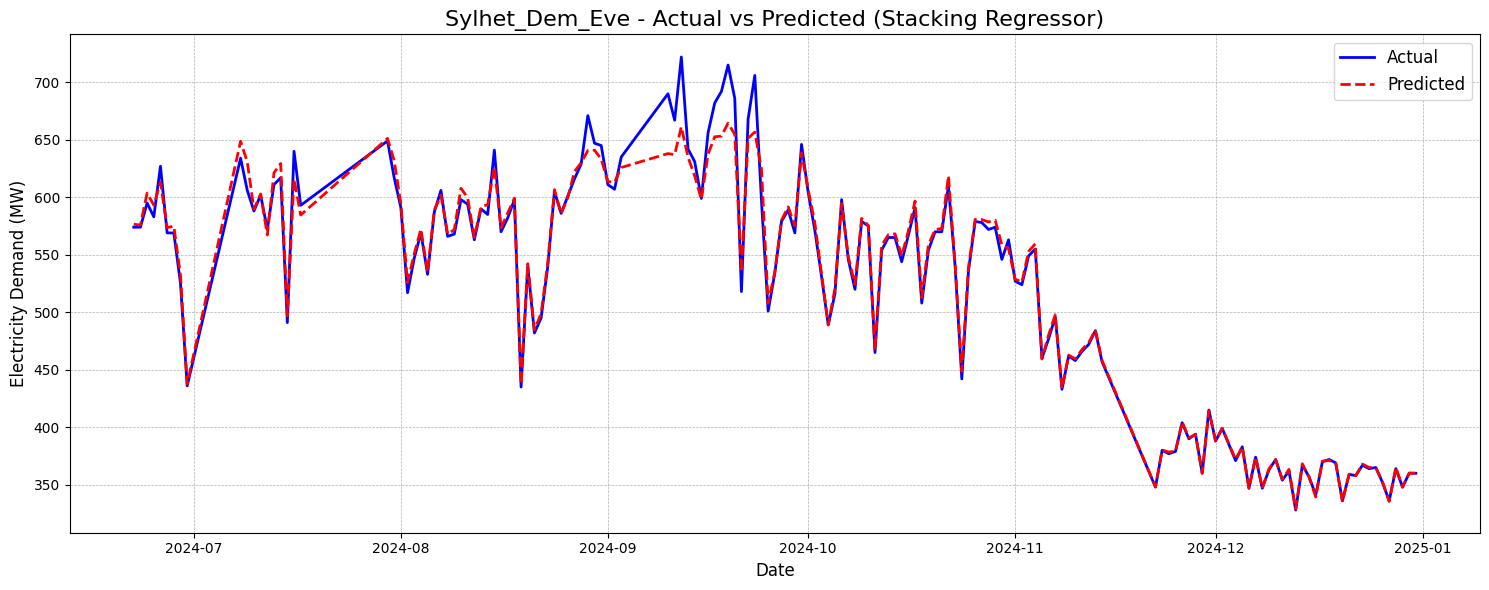

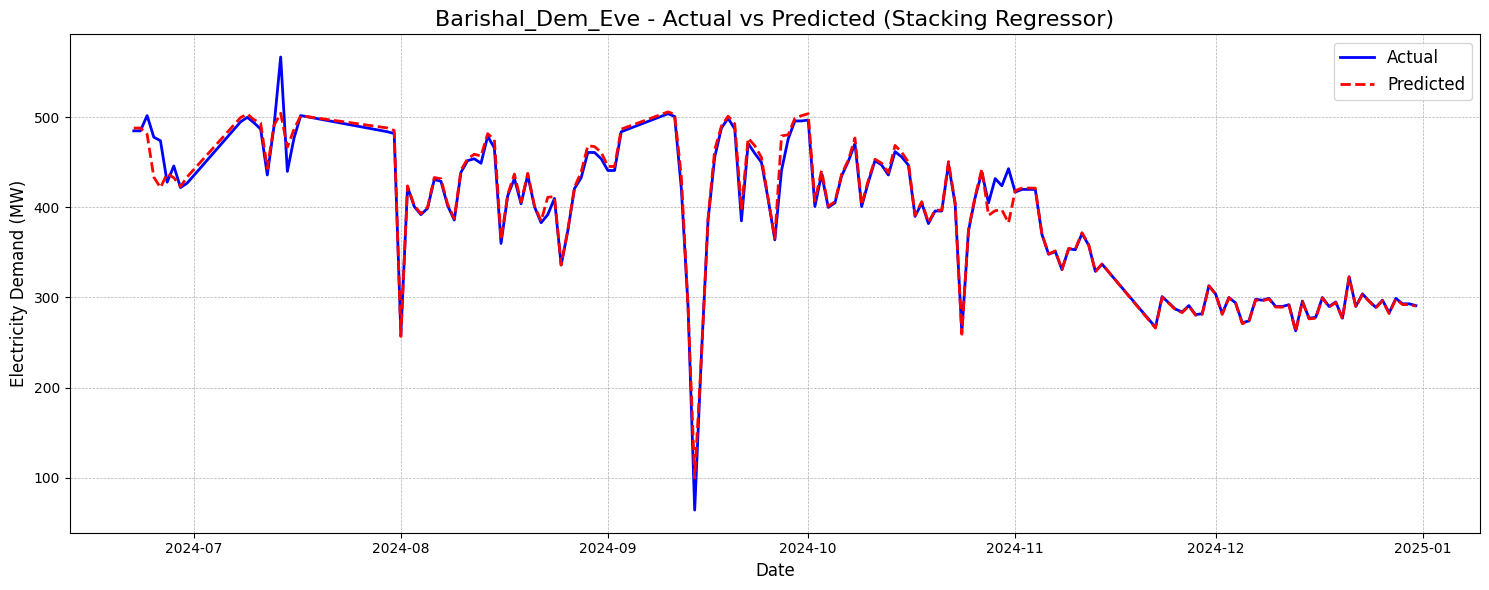

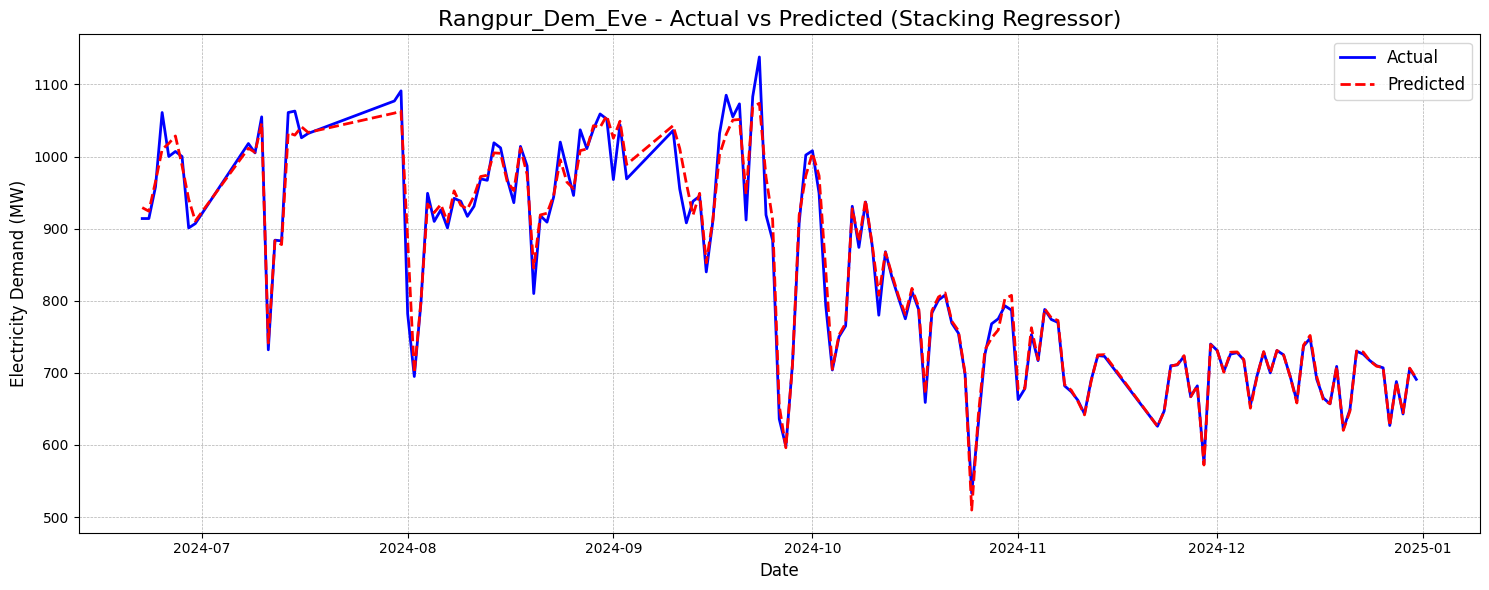


--- All plots for the specified date range generated. ---


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

print("--- Generating Actual vs. Predicted Plots for 2022-2023 ---")

# Ensure the fitted stacking model ('wrapped_stacking_regressor') and test data are available
# Get the predictions from the stacking model
y_pred_stacking = wrapped_stacking_regressor.predict(X_test_scaled)

# Convert the predictions array into a DataFrame with the correct column names and index
y_pred_df = pd.DataFrame(y_pred_stacking, index=y_test.index, columns=y_test.columns)

# Define the date range you want to plot
start_date = '2023-01-01'
end_date = '2024-12-31'

# Loop through each target column (each zone) to create a plot
for zone_column in y_test.columns:
    # --- ADDED: Filter the data for the specified date range ---
    y_test_filtered = y_test.loc[start_date:end_date]
    y_pred_filtered = y_pred_df.loc[start_date:end_date]

    # Check if there is data in the selected range before plotting
    if y_test_filtered.empty:
        print(f"No data available for {zone_column} in the range {start_date} to {end_date}. Skipping plot.")
        continue

    plt.figure(figsize=(15, 6)) # Create a new figure for each plot

    # Plot the actual values from the filtered data
    plt.plot(y_test_filtered.index, y_test_filtered[zone_column], 'b-', label='Actual', linewidth=2)

    # Plot the predicted values from the filtered data
    plt.plot(y_pred_filtered.index, y_pred_filtered[zone_column], 'r--', label='Predicted', linewidth=2)

    # --- Formatting the plot ---
    plt.title(f'{zone_column} - Actual vs Predicted (Stacking Regressor)', fontsize=16)
    plt.ylabel('Electricity Demand (MW)', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Show the plot for the current zone
    plt.show()

print("\n--- All plots for the specified date range generated. ---")